In [31]:
#import data
import pandas as pd
url = "https://storage.googleapis.com/adsp-nlp-open/data/elsevier-oa-cc-by/abstracts.json"
data = pd.read_json(url, orient="records")

In [32]:
# View the target data columns
data.head()
subject=data['subject'].unique()
print(subject)

['phys_sci' 'healh_sci' 'engi_tech' 'life_sci' 'soc_sci']


The data comes with "title" and "abstract" fields. You may use either (or both) for your modeling.
Using both gave better results hence using it to compare the models using techniques of BOW and Lemmatization

In [33]:
#import labelencoder and combine 2 columns
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
#fit the encoder
data['subject_encoded']=encoder.fit_transform(data['subject'])
data['text']=data['abstract']+' ' +data['title']

In [34]:
#clean
import re
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text=text.lower()  # Convert to lowercase
    return text.strip() 

data['cleaned_text'] = data['text'].apply(clean_text)


In [35]:
#vectorization using bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words='english')  # Limit to 1000 features for simplicity
X = vectorizer.fit_transform(data['cleaned_text'])
#target variable
y = data['subject_encoded']
#get feature names
words=vectorizer.get_feature_names_out()

In [36]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model 1: Ensemble of 1000 logistic regression model using BOW

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words='english')  # Limit to 1000 features for simplicity
X = vectorizer.fit_transform(data['cleaned_text'])

# Step 2: Define the target variable
y = data['subject_encoded']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize the Logistic Regression model
classifier1 = LogisticRegression(max_iter=1000)

# Step 5: Create an ensemble of Logistic Regression models using BaggingClassifier
ensemble = BaggingClassifier(estimator=classifier1, n_estimators=1000, random_state=42, n_jobs=-1)

# Step 6: Train the ensemble model
ensemble.fit(X_train, y_train)

# Step 7: Predict on the test set
y_pred1 = ensemble.predict(X_test)

# Step 8: Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred1)
class_report = classification_report(y_test, y_pred1, target_names=encoder.classes_)

# Print results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)


Accuracy: 0.6539157405014215
Classification Report:
              precision    recall  f1-score   support

   engi_tech       0.71      0.70      0.71      1809
   healh_sci       0.75      0.72      0.73      1525
    life_sci       0.60      0.47      0.53      1191
    phys_sci       0.60      0.68      0.64      2578
     soc_sci       0.60      0.60      0.60       635

    accuracy                           0.65      7738
   macro avg       0.65      0.63      0.64      7738
weighted avg       0.66      0.65      0.65      7738



In [43]:
#confusion matrix of model 1
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred1)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix Model 1')
plt.show()

ValueError: Inconsistent sample sizes: y_test (19572) and y_pred1 (7738)

<Figure size 1000x700 with 0 Axes>

#Model 2: Using Logistic regression with Lemmatization + BOW for prediction

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean and lemmatize text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    
    # Lemmatize each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a string
    return " ".join(tokens)

# Assuming 'data' is a DataFrame with 'cleaned_abstract' and 'subject_encoded' columns
data['cleaned_text_lemmatized'] = data['cleaned_text'].apply(preprocess_text)

# Vectorize the cleaned abstract using CountVectorizer or TfidfVectorizer
vectorizer = CountVectorizer(max_features=1000)  # Limit to 1000 features for simplicity
XX = vectorizer.fit_transform(data['cleaned_text_lemmatized'])

# Target variable
y = data['subject_encoded']

# Split the data into training and testing sets
XX_train, XX_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression classifier
classifier2 = LogisticRegression(max_iter=500)  # Increase max_iter to ensure convergence

# Train the model
classifier2.fit(XX_train, y_train)

# Make predictions
y_pred2 = classifier2.predict(XX_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred2)
class_report = classification_report(y_test, y_pred2, target_names=encoder.classes_)

# Print results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cicily.mathew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cicily.mathew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy: 0.6561126906177307
Classification Report:
              precision    recall  f1-score   support

   engi_tech       0.71      0.71      0.71      1809
   healh_sci       0.74      0.72      0.73      1525
    life_sci       0.61      0.46      0.53      1191
    phys_sci       0.60      0.68      0.64      2578
     soc_sci       0.60      0.62      0.61       635

    accuracy                           0.66      7738
   macro avg       0.65      0.64      0.64      7738
weighted avg       0.66      0.66      0.65      7738



In [ ]:
#confusion matrix of model 2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred2)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix Model 2')
plt.show()

#Model3: Random forest Classifier with N-Grams

In [39]:
# Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# Install imbalanced-learn if not already installed
%pip install imbalanced-learn

# Import SMOTE from imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Step 2: Vectorize the Text using TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 3))  
X = vectorizer.fit_transform(data['cleaned_text'])

# Step 3: Balance Classes using SMOTE (Synthetic Minority Over-sampling Technique)
y = data['subject_encoded']

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

# Step 4: Split the Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Step 5: Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Step 6: Fine-Tune the Model using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Step 7: Evaluate the Model
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred3 = best_model.predict(X_test)

# Step 8: Evaluate the performance of the model
print("Classification Report:")
print(classification_report(y_test, y_pred3))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred3))
# Visualize the confusion matrix





Fitting 2 folds for each of 54 candidates, totalling 108 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      3938
           1       0.85      0.88      0.86      3937
           2       0.86      0.81      0.84      3856
           3       0.69      0.59      0.63      3899
           4       0.88      0.95      0.91      3942

    accuracy                           0.81     19572
   macro avg       0.81      0.81      0.81     19572
weighted avg       0.81      0.81      0.81     19572

Confusion Matrix:
[[3305   68   51  366  148]
 [  24 3445  130  249   89]
 [ 127  171 3140  332   86]
 [ 786  360  291 2291  171]
 [  79   29   22   81 3731]]


<Figure size 1000x700 with 0 Axes>

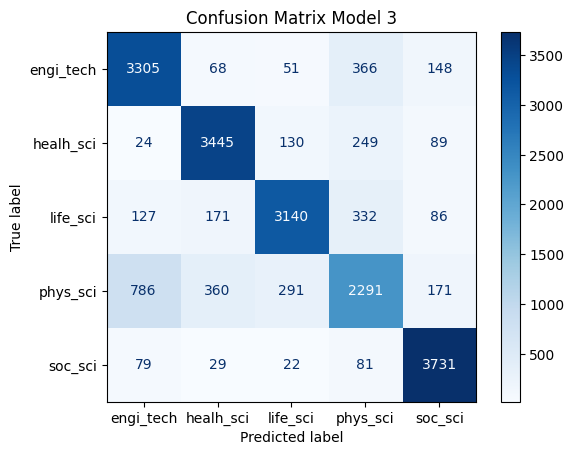

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred3)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix Model 3')
plt.show()

What kind of models did you try and why?

Tried different variations of Logistic regression with each column seperately and combined along with SVM and random forest classifier with techniques BOW, N-GRAM MODELS(1-3) and lemmatization. Final 3 models are #Model 1: Ensemble of 1000 logistic regression model using BOW, #Model 2: Using Logistic regression with Lemmatization for prediction, #Model3: Random forest Classifier with N-grams.

How did you evaluate the model and which metric do you think is most important.
Focus on evaluating the model based on accuracy rather than performance, as the university prioritizes relevance for search results. The model can run overnight to classify the documents, so performance is less of a concern.

How did you investigate misclassifications?

Misclassifications were investigated with classification report, confusion matrix and further by probablistic approach of taking the probabilities of each class and then manually looking at the classes and their misclassifications.

In [ ]:
import numpy as np

num_top_words = 10


# Get feature importances from the Random Forest model
weights = best_model.feature_importances_

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Iterate over each class with correct class label
for class_label in range(len(best_model.classes_)):

    # Sort the features by their importance for the current class
    top_features = np.argsort(weights)[-num_top_words:][::-1]

    # Extract top words and their corresponding importance
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_weights = [weights[feat_idx] for feat_idx in top_features]  # Extract corresponding importances

    # Print words with importances
    print(f"\nTop words for class {best_model.classes_[class_label]}:")
    for word, weight in zip(top_words, top_weights):
        print(f"{word}: {weight:.4f}")  # Display the feature importance (not log prob)



Top words for class 0:
paper: 0.0187
patients: 0.0118
social: 0.0104
energy: 0.0098
background: 0.0095
disease: 0.0087
species: 0.0086
methods: 0.0084
evidence: 0.0080
clinical: 0.0074

Top words for class 1:
paper: 0.0187
patients: 0.0118
social: 0.0104
energy: 0.0098
background: 0.0095
disease: 0.0087
species: 0.0086
methods: 0.0084
evidence: 0.0080
clinical: 0.0074

Top words for class 2:
paper: 0.0187
patients: 0.0118
social: 0.0104
energy: 0.0098
background: 0.0095
disease: 0.0087
species: 0.0086
methods: 0.0084
evidence: 0.0080
clinical: 0.0074

Top words for class 3:
paper: 0.0187
patients: 0.0118
social: 0.0104
energy: 0.0098
background: 0.0095
disease: 0.0087
species: 0.0086
methods: 0.0084
evidence: 0.0080
clinical: 0.0074

Top words for class 4:
paper: 0.0187
patients: 0.0118
social: 0.0104
energy: 0.0098
background: 0.0095
disease: 0.0087
species: 0.0086
methods: 0.0084
evidence: 0.0080
clinical: 0.0074


Were the misclassifications understandable (genuinely difficult examples) or were they blatant errors? Provide a few examples.

Looking at the 5 examples of misclassification samples generated in the below code we can clearly see the challenge due to the overlap in domain-specific terms like 'technology' being mentioned in reference to a health consequence. Hence some were understandable but there were few blatant errors as well.

1. "Post-acute consequences currently form a significant component of the dengue disability-adjusted life year (DALY) burden estimates. However, there is considerable uncertainty regarding the incidence, duration, and severity of these symptoms. Further research is needed to more accurately estimate the health and economic burden of these dengue manifestations. The Uncertainty Surrounding the Burden of Post-acute Consequences of Dengue Infection"

Looks like the Eng-tech paper was tagged as phy-sci as it lacks strong keywords typically associated with the engineering technology domain, leading to its misclassification.

2. Vibro-acoustic source characterization is an essential task in vehicle development to enable prediction of receiver response. For structure-borne noise, the interface forces in multiple degrees of freedom due to internal loads are often quantified for root cause analyses in a single system assembly, as in transfer path analysis (TPA). However, for a reliable prognosis of the acoustic performance of a known component such as a motor or pump, a receiver-independent source characterization is required, and the method of acquiring blocked forces ...............". 

Looks like this miclassification could be a pure blunter as there are many engineering specific words mentioned but the most common ones were not present.  


In [59]:
pred_probas = best_model.predict_proba(X_test).round(3) # probabilities for each class

X_test_df = (
    pd.DataFrame(X_test.toarray())  # Convert sparse matrix to dense DataFrame
    .assign( # adding actual and predicted labels
        actual_label=encoder.inverse_transform(y_test),
        predicted_label=encoder.inverse_transform(pred_probas.argmax(axis=1)),
    )
    .reset_index(drop=True)
)

pred_proba_df = pd.DataFrame(pred_probas, columns=encoder.classes_) # adding probabilities for each class
results_df = pd.concat([X_test_df, pred_proba_df], axis=1)

In [ ]:
import pandas as pd

# Step 1: Get the predicted labels
predicted_labels = best_model.predict(X_test)

# Step 2: Get predicted probabilities
pred_probas = best_model.predict_proba(X_test).round(3)

# Step 3: Reverse the encoding of the actual labels
X_test_df = (
    pd.DataFrame(X_test.toarray())  # Convert sparse matrix to dense DataFrame
    .assign(  # Adding actual and predicted labels
        actual_label=encoder.inverse_transform(y_test),
        predicted_label=encoder.inverse_transform(predicted_labels),
    )
    .reset_index(drop=True)
)

# Step 4: Add predicted probabilities for each class
pred_proba_df = pd.DataFrame(pred_probas, columns=encoder.classes_)

# Step 5: Combine both DataFrames
results_df = pd.concat([X_test_df, pred_proba_df], axis=1)

# Step 6: Filter misclassified rows
misclassified_df = results_df[results_df['actual_label'] != results_df['predicted_label']]



Misclassified samples:
   actual_label predicted_label  engi_tech  healh_sci  life_sci  phys_sci  \
1     engi_tech        phys_sci      0.245      0.020     0.090     0.595   
4     engi_tech       healh_sci      0.100      0.275     0.235     0.195   
15     phys_sci       engi_tech      0.515      0.020     0.040     0.390   
17     phys_sci       engi_tech      0.575      0.005     0.070     0.350   
18    engi_tech        phys_sci      0.325      0.050     0.260     0.355   

    soc_sci  
1     0.050  
4     0.195  
15    0.035  
17    0.000  
18    0.010  


In [60]:

# Merge the misclassified_df with the original 'data['text']' column using the index
misclassified_with_text = misclassified_df.merge(
    data[['text']], left_index=True, right_index=True, how='left'
)

# Step 2: Display the misclassified rows with the actual text
print("Misclassified samples with text:")
print(misclassified_with_text[['text', 'actual_label', 'predicted_label', *encoder.classes_]].head())
# Save the misclassified samples to a CSV file
misclassified_with_text.to_csv('misclassified_samples.csv', index=False)


Misclassified samples with text:
                                                 text actual_label  \
1   Post-acute consequences currently form a signi...    engi_tech   
4   Vibro-acoustic source characterization is an e...    engi_tech   
15  Does personality predict how people feel in di...     phys_sci   
17  The use of a highly resistive transparent (HRT...     phys_sci   
18  We consider tropical hemispaces, defined as tr...    engi_tech   

   predicted_label  engi_tech  healh_sci  life_sci  phys_sci  soc_sci  
1         phys_sci      0.245      0.020     0.090     0.595    0.050  
4        healh_sci      0.100      0.275     0.235     0.195    0.195  
15       engi_tech      0.515      0.020     0.040     0.390    0.035  
17       engi_tech      0.575      0.005     0.070     0.350    0.000  
18        phys_sci      0.325      0.050     0.260     0.355    0.010  
